<a href="https://colab.research.google.com/github/HJ-LIM-DS/LLM2025/blob/main/english_news_summary_without_chatgpt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install newspaper3k transformers torch matplotlib wordcloud
!pip install openai==0.28.0
!pip install "lxml[html_clean]"

  Using cached newspaper3k-0.2.8-py3-none-any.whl.metadata (11 kB)
  Using cached cssselect-1.3.0-py3-none-any.whl.metadata (2.6 kB)
  Using cached feedparser-6.0.11-py3-none-any.whl.metadata (2.4 kB)
  Using cached tldextract-5.3.0-py3-none-any.whl.metadata (11 kB)
  Using cached feedfinder2-0.0.4.tar.gz (3.3 kB)
  Preparing metadata (setup.py) ... done
  Using cached jieba3k-0.35.1.zip (7.4 MB)
  Preparing metadata (setup.py) ... done
  Using cached tinysegmenter-0.3.tar.gz (16 kB)
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.

In [8]:
import matplotlib.pyplot as plt
from newspaper import Article
from transformers import pipeline
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import torch

In [9]:
# 1) Summarizer 초기화 (CPU 모드)
summarizer = pipeline(
    "summarization",
    model="facebook/bart-large-cnn",
    tokenizer="facebook/bart-large-cnn",
    device=-1
)
tokenizer = summarizer.tokenizer
model     = summarizer.model

# 모델이 받아들일 수 있는 최대 입력 토큰 수 (대개 1024)
max_input_tokens = tokenizer.model_max_length

def chunked_summarize_by_token(text: str, chunk_size_tokens: int = 800) -> str:
    """
    1) 텍스트 전체를 tokenizer로 id 리스트로 변환
    2) chunk_size_tokens 단위로 잘라서 요약
    3) 결과 합치기
    """
    # 전체 텍스트를 토큰 ID로 변환 (truncation=False)
    enc = tokenizer(text, return_tensors="pt", truncation=False)
    input_ids = enc["input_ids"][0]

    summaries = []
    # 토큰 리스트를 chunk_size_tokens 간격으로 분할
    for i in range(0, input_ids.size(0), chunk_size_tokens):
        chunk_ids = input_ids[i : i + chunk_size_tokens]
        attn_mask = torch.ones_like(chunk_ids).unsqueeze(0)

        # 요약 생성
        summary_ids = model.generate(
            chunk_ids.unsqueeze(0),
            attention_mask=attn_mask,
            max_length=150,
            min_length=30,
            do_sample=False
        )
        summaries.append(tokenizer.decode(summary_ids[0], skip_special_tokens=True))

    return " ".join(summaries)

def fetch_and_summarize(url: str) -> str:
    """
    - newspaper3k 로 기사 본문 추출
    - token-based chunked 요약 수행
    """
    article = Article(url, language='en')
    article.download()
    article.parse()
    return chunked_summarize_by_token(article.text)

def visualize_summary(summary: str):
    """
    - 워드클라우드와 단어 빈도 분석 시 기본 불용어를 제외하도록 수정
    """
    # 1) 기본 불용어 세트
    stopwords = set(STOPWORDS)
    # 필요하면 여기에 추가로 불용어를 더할 수 있습니다.
    custom_stopwords = {"'", '"', '“', '”', '‘', '’', '–', '—', '.', ',', '?', '!', ':', ';', '(', ')', '[', ']', '{', '}', '<', '>', '/', '\\', '|', '+', '-', '_', '=', '*', '&', '^', '%', '$', '#', '@', '~', '`', '…', '•', '·', '«', '»', 'the', 'is', 'of', 'and', 'in', 'to', 'a', 'that', 'it', 'for', 'on', 'with', 'as', 'at', 'this', 'by', 'from', 'or', 'be', 'an', 'are', 'was', 'were', 'has', 'had', 'have', 'not', 'but', 'if', 'they', 'you', 'we', 'us', 'so', 'such', 'these', 'those'}

    stopwords |= custom_stopwords

    # 2) 워드클라우드
    wc = WordCloud(
        width=800, height=400,
        background_color='white',
        stopwords=stopwords,       # 불용어 적용
    ).generate(summary)
    plt.figure(figsize=(12, 6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title("wordcloud summary")
    plt.show()

    # 3) 단어 빈도 계산 시 불용어 제거
    words = [
        w.lower().strip('.,!?:;"\'')  # 소문자, 양쪽 구두점 제거
        for w in summary.split()
        if w.lower() not in stopwords
    ]
    freq = Counter(words)
    top10 = freq.most_common(10)
    labels, counts = zip(*top10)

    plt.figure(figsize=(10, 5))
    plt.bar(labels, counts)
    plt.xticks(rotation=45, ha='right')
    plt.title("top 10 most frequent")
    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu
Device set to use cpu


openai API key 토큰 upper limit을 걸어두었습니다^^ API KEY는 중간고사 종료 후 폐기할 예정입니다!

뉴스 기사 URL 입력 (영어 기사만) EX. https://time.com/7280106/trump-interview-100-days-2025/

In [12]:
#url = input("신문기사 URL을 입력하세요: ").strip()
url = "https://time.com/7280106/trump-interview-100-days-2025/"


▶️ newspaper3k + BART 요약 생성 중…

--- 자동 요약 ---
 The Oval Office is filled with portraits of other presidents in gilded frames. The molding and mantels have gold accents now. Trump has hung an early copy of the Declaration of Independence behind a set of blue curtains.


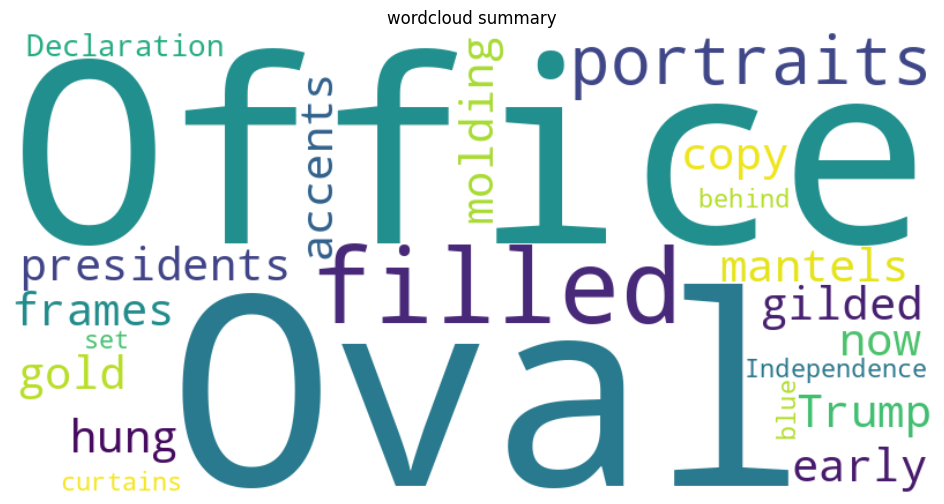

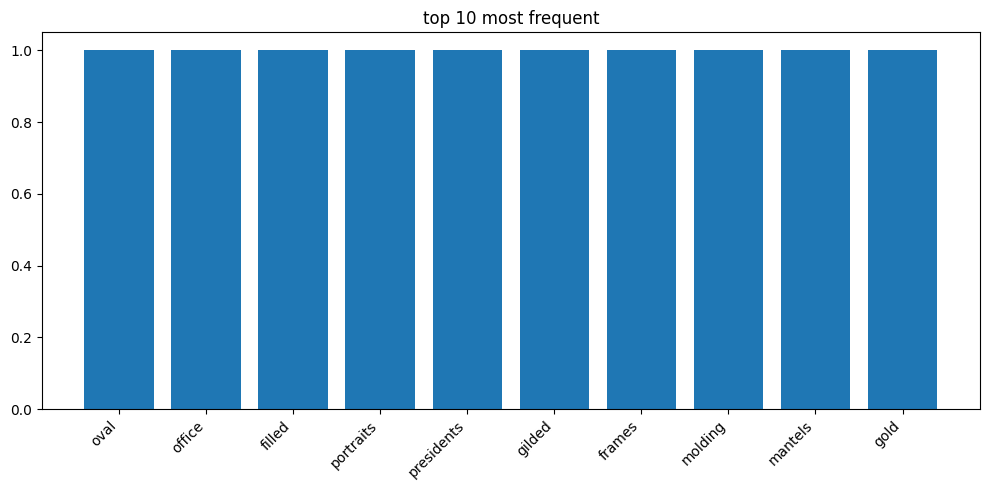


▶️ newspaper3k + BART 요약 생성 중…

--- 자동 요약 ---
 The Oval Office is filled with portraits of other presidents in gilded frames. The molding and mantels have gold accents now. Trump has hung an early copy of the Declaration of Independence behind a set of blue curtains.


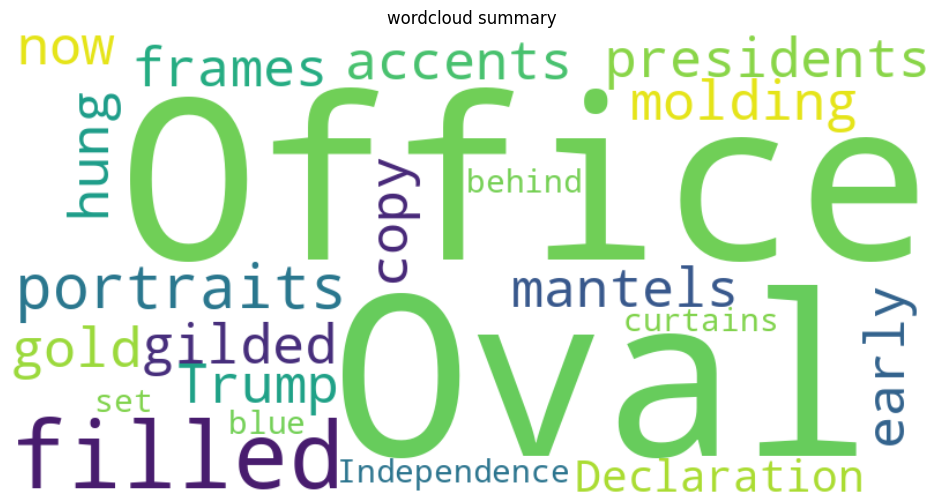

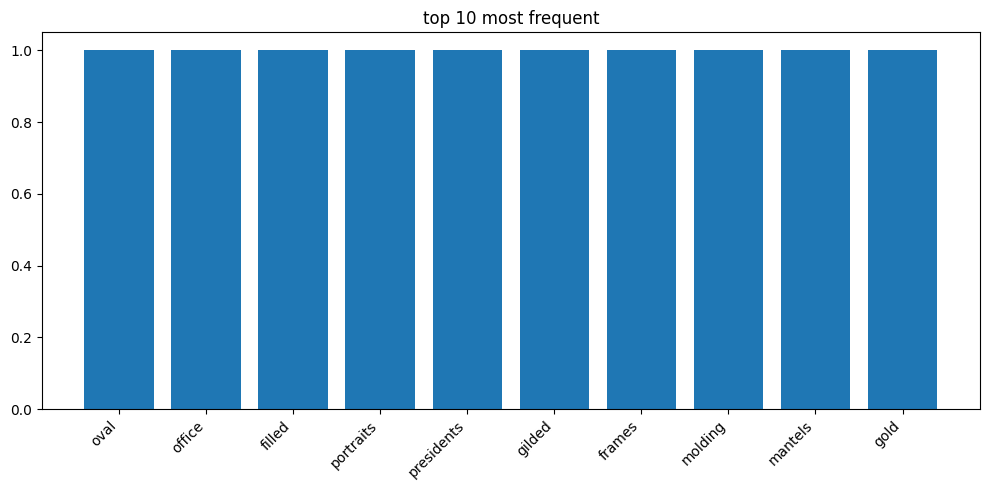

In [13]:
#기존 fetch_and_summarize 후 또는 별도 호출
if __name__ == "__main__":
    print("\n▶️ newspaper3k + BART 요약 생성 중…")
    summary = fetch_and_summarize(url)

    visualize_summary(summary)